In [1]:
using DrWatson
@quickactivate "Doran_etal_2022"

In [10]:
using Muon
using Distances
using StatsPlots
using NewickTreeTools
using Phylo
using SPI
using MAT

In [3]:
using Statistics

In [189]:
pdir = plotsdir("donorspecificity")
mkpath(pdir)

"/Users/ben/projects/Doran_etal_2022/plots/donorspecificity"

In [4]:
biobank = readh5mu(joinpath(datadir(), "exp_pro", "BB673", "BB673.h5mu"))
uniprot = readh5ad(joinpath(datadir(), "exp_pro", "UP7047", "2020_02_UP7047.h5ad"));


In [5]:
# Match BioBank measurements to column order of UniProt
bbmtx = zeros(size(biobank["oggs"].X, 1), length(uniprot.var_names.vals));
rawidxs = indexin(biobank["oggs"].var_names.vals, uniprot.var_names.vals)
bbmask = .!isnothing.(rawidxs)
uporderedmask = filter(x->.!isnothing(x), rawidxs);
bbmtx[:, uporderedmask] .= biobank["oggs"].X[:, :][:, bbmask];

In [12]:
UPvsBB = matread(datadir("exp_pro", "BB673", "UPvsBBdists.mat"))["dists"];
BBspimtx = UPvsBB[7048:end, 7048:end];

In [13]:
inferredeuclidean_hc = hclust(BBspimtx, linkage=:average, branchorder=:optimal)
inferredeuclidean_nws = SPI.nwstr(inferredeuclidean_hc, biobank.obs_names.vals; labelinternalnodes=false);
inferredeuclidean_tree = readnw(inferredeuclidean_nws);

In [17]:
leaves = NewickTree.getleaves(inferredeuclidean_tree);
leafid = findfirst(x->contains(name(x),"MSK.17.15"), leaves)
compose(f, n) = reduce(∘, ntuple(_ -> f, n))
subtree = compose(parent, 2)(leaves[leafid]);

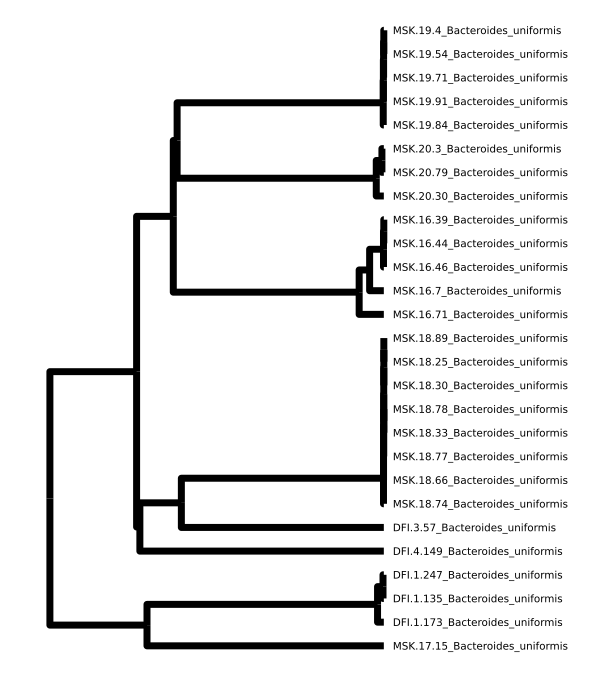

In [18]:
plotsubtree = parsenewick(NewickTree.nwstr(subtree))
sort!(plotsubtree)
plot(plotsubtree, rightmargin=4Plots.Measures.cm, lw=7, size=(600, 700))

In [25]:
plotsubtree

RootedTree with 27 tips, 53 nodes and 52 branches.
Leaf names are MSK.17.15_Bacteroides_uniformis, DFI.1.173_Bacteroides_uniformis, DFI.1.135_Bacteroides_uniformis, DFI.1.247_Bacteroides_uniformis, DFI.4.149_Bacteroides_uniformis, ... [21 omitted] ... and MSK.19.4_Bacteroides_uniformis


In [16]:
UPusv = SVD(uniprot.obsm["LSVs"][:, :], uniprot.uns["SVs"][:], uniprot.varm["RSVs"][:, :]');

In [22]:
BBuhat = projectinLSV(bbmtx, UPusv);

673×7047 Matrix{Float64}:
 -0.00710957  -0.016346   0.0109378   …   0.0620108   -0.195298
 -0.0101422   -0.0235557  0.0183793       0.290321    -0.216655
 -0.00988477  -0.0228117  0.0172847       0.197863    -0.268172
 -0.00911707  -0.0213556  0.0163378      -0.201534    -0.00658134
 -0.0100938   -0.0234382  0.0181515      -0.245223    -0.123784
 -0.0100751   -0.0234404  0.018099    …  -0.247896    -0.121264
 -0.0126152   -0.0291861  0.0252202      -0.204816    -0.265976
 -0.00982738  -0.0232259  0.0177415      -0.25874     -0.253145
 -0.0130485   -0.0308516  0.0269812      -0.270194     0.0506157
 -0.00927287  -0.0215109  0.0162395      -0.171792    -0.0400535
  ⋮                                   ⋱   ⋮           
 -0.00895884  -0.0207339  0.0178657       0.106219    -0.317428
 -0.00903688  -0.0208161  0.0180687   …   0.118437    -0.345223
 -0.0129656   -0.0307315  0.027649       -0.133769    -0.110028
 -0.00931925  -0.0204614  0.0181975      -0.00752627  -0.526419
 -0.00569943  -0.01

In [27]:
d16uniformis_idxs = 

5-element Vector{Int64}:
 277
 609
 613
 616
 619

In [58]:
idxs = union(
    findall(x->contains(x,"vulgatus"), biobank.obs.species), 
    findall(x->contains(x,"gnavus"), biobank.obs.species)
    )

135-element Vector{Int64}:
   4
   8
  10
  11
  14
 134
 135
 136
 137
 138
   ⋮
 532
 533
 534
 535
 536
 537
 538
 620
 621

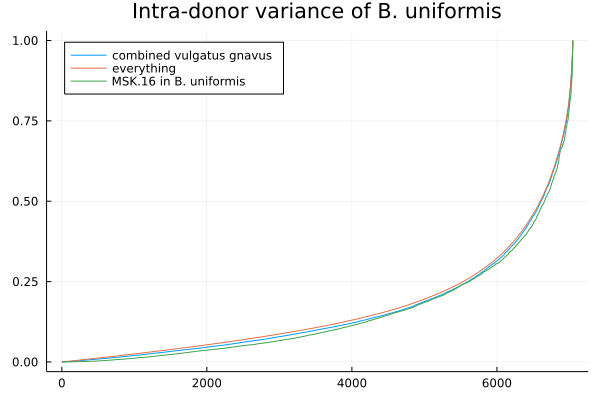

In [76]:
plot(title="Intra-donor variance of B. uniformis",
    legend=:topleft)
idxs = union(
    findall(x->contains(x,"vulgatus"), biobank.obs.species), 
    findall(x->contains(x,"gnavus"), biobank.obs.species))
plot!(scaledcumsum(mapslices(var, BBuhat[idxs, :], dims=1)[:]), label="combined vulgatus gnavus")
plot!(scaledcumsum(mapslices(var, BBuhat, dims=1)[:]), label="everything")
for donorid in [ 16,] # 18, 19, 20, 1,
    idxs = intersect(findall(x->contains(x,".$donorid."), biobank.obs_names), findall(x->contains(x,"uniformis"), biobank.obs.species))
    plot!(scaledcumsum(mapslices(var, BBuhat[idxs, :], dims=1)[:]), label="MSK.$donorid in B. uniformis")
end
plot!()

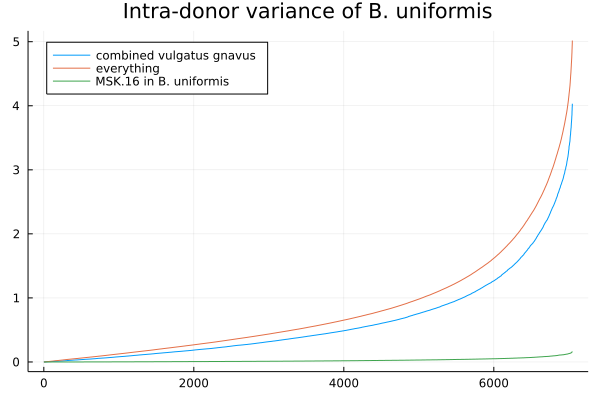

In [ ]:
plot(title="Intra-donor variance of B. uniformis",
    legend=:topleft)
idxs = union(
    findall(x->contains(x,"vulgatus"), biobank.obs.species), 
    findall(x->contains(x,"gnavus"), biobank.obs.species))
plot!(cumsum(mapslices(var, BBuhat[idxs, :], dims=1)[:]), label="combined vulgatus gnavus")
plot!(cumsum(mapslices(var, BBuhat, dims=1)[:]), label="everything")
for donorid in [ 16,] # 18, 19, 20, 1,
    idxs = intersect(findall(x->contains(x,".$donorid."), biobank.obs_names), findall(x->contains(x,"uniformis"), biobank.obs.species))
    plot!(cumsum(mapslices(var, BBuhat[idxs, :], dims=1)[:]), label="MSK.$donorid in B. uniformis")
end
plot!()

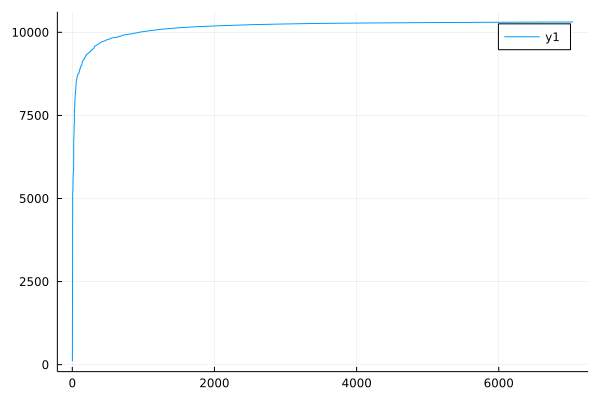

In [66]:
plot(title="Intra-donor variance of B. uniformis",
    legend=:topleft)
bidxs = findall(x->contains(x,"vulgatus"), biobank.obs.species)
ridxs = findall(x->contains(x,"gnavus"), biobank.obs.species)
vcat(mapslices(mean, BBuhat[bidxs, :] * diagm(UPusv.S), dims=1),
     mapslices(mean, BBuhat[ridxs, :] * diagm(UPusv.S), dims=1)) |>
    m->mapslices(var, m, dims=1)[:] |>
    cumsum |>
    plot

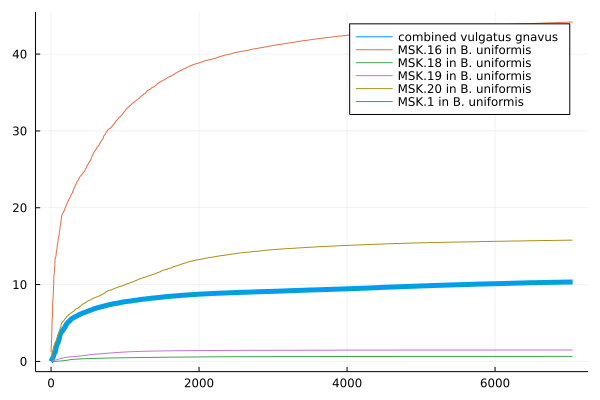

In [72]:
plot(cumsum(mapslices(var, BBuhat[idxs, :] * diagm(UPusv.S), dims=1)[:]), lw=5, label="combined vulgatus gnavus")
# plot!(cumsum(mapslices(var, BBuhat, dims=1)[:]), label="everything")
for donorid in [ 16,  18, 19, 20, 1,]
    idxs = intersect(findall(x->contains(x,".$donorid."), biobank.obs_names), findall(x->contains(x,"uniformis"), biobank.obs.species))
    plot!(cumsum(mapslices(var, BBuhat[idxs, :] * diagm(UPusv.S), dims=1)[:]), label="MSK.$donorid in B. uniformis")
end
plot!()

In [78]:
idxs

5-element Vector{Int64}:
 277
 609
 613
 616
 619

In [218]:
r_idxs = occursin.("luti", biobank.obs.species) |> findall
b_idxs = occursin.("uniformis", biobank.obs.species) |> findall;
# popat!(b_vulgatus_idxs, occursin.("MSK.7.24", biobank.obs_names[b_vulgatus_idxs]) |> findfirst)
donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2) |>
    v -> parse.(Int,v)

b_idxs = b_idxs[sortperm(donorid[b_idxs])]
r_idxs = r_idxs[sortperm(donorid[r_idxs])]

idxs = union(b_idxs,  r_idxs);

In [219]:
pairedtraces = calc_spi_trace(BBuhat[idxs,:], UPusv.S, getintervals(UPusv.S));

In [220]:
SPItraces = mapslices(cumsum, pairedtraces, dims=1);

In [221]:
size(SPItraces)

(880, 1275)

In [276]:
b_idxs

27-element Vector{Int64}:
 273
 275
 610
 611
 612
 277
 609
 613
 616
 619
   ⋮
 618
 274
 276
 604
 606
 607
 272
 278
 608

In [222]:
phylumid[idxs] |> unique

2-element Vector{String}:
 "Bacteroides uniformis"
 "Blautia luti"

In [223]:
lowertriangle = tril(trues(length(idxs), length(idxs)), -1);

phylumid = biobank.obs.species
phylumpairmask = pairwise(!=, phylumid[idxs])[lowertriangle]

speciesid = biobank.obs.species
speciespairs = pairwise(==, speciesid[idxs])[lowertriangle]

donorid = biobank.obs_names |>
    v -> split.(v, ".") |>
    v -> getindex.(v, 2)
donorpairs = pairwise(==, donorid[idxs])[lowertriangle]
donorpairmask = donorpairs .&& speciespairs
speciespairmask = speciespairs .&& (.!donorpairmask);

In [224]:
sum(phylumpairmask), sum(speciespairmask), sum(donorpairmask)

(648, 561, 66)

In [225]:
(sum(phylumpairmask), sum(speciespairmask), sum(donorpairmask)) |> sum

1275

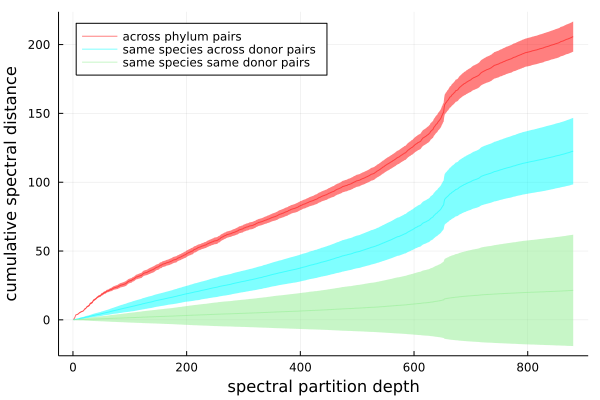

In [200]:
plot(legend=:topleft, ylabel="cumulative spectral distance", xlabel="spectral partition depth")
p_mean = mapslices(mean, SPItraces[:, phylumpairmask], dims=2)[:]
p_std = mapslices(std, SPItraces[:, phylumpairmask], dims=2)[:];
plot!(p_mean, ribbon=p_std, c=:red, alpha=.5, label="across phylum pairs")

s_mean = mapslices(mean, SPItraces[:, speciespairmask], dims=2)[:]
s_std = mapslices(std, SPItraces[:, speciespairmask], dims=2)[:];
plot!(s_mean, ribbon=s_std, c=:aqua, alpha=.5, label="same species across donor pairs")

d_mean = mapslices(mean, SPItraces[:, donorpairmask], dims=2)[:]
d_std = mapslices(std, SPItraces[:, donorpairmask], dims=2)[:];
plot!(d_mean, ribbon=d_std, c=:lightgreen, alpha=.5, label="same species same donor pairs")

In [ ]:
plot(legend=:topleft, ylabel="cumulative spectral distance", xlabel="spectral partition depth")
plot!(SPItraces[:, donorpairmask], c=:lightgreen, alpha=.2, label="")
plot!(SPItraces[:, speciespairmask], c=:aqua, alpha=.2, label="")
plot!(SPItraces[:, phylumpairmask], c=:red, alpha=.2, label="")
plot!([0 0 0], c=[:red :aqua :lightgreen], 
    label=["Blautia luti:Bacteroides uniformis pairs" "within species across donor pairs" "within species and donor pairs"])
vline!([90], c=:black, linestyle=:dash, label="")

In [254]:
savefig(joinpath(pdir, "SPItraces_of_Bluti_and_Buniformis.pdf"))

In [255]:
partitions = getintervals(UPusv.S);

In [256]:
partitions[35]

35:35

In [257]:
partitions[100]

101:101

In [258]:
pMprime = BBuhat[idxs, 1:90] * diagm(UPusv.S[1:90]) * UPusv.Vt[1:90, :]
dMprime = BBuhat[idxs, 91:end] * diagm(UPusv.S[91:end]) * UPusv.Vt[91:end, :];

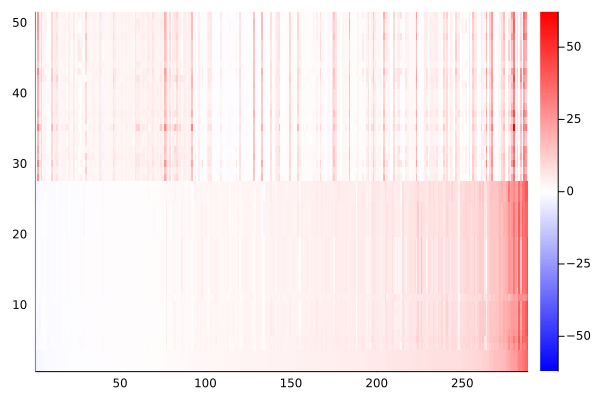

In [266]:
differentialgenes = findall(>(1), mapslices(var, pMprime, dims=1)[:])
cl = maximum(abs.(extrema(pMprime[:, differentialgenes])))
cls = (-cl, cl)
# hc = hclust(pairwise(Euclidean(), pMprime[:, differentialgenes]), branchorder=:optimal)
heatmap(pMprime[:, differentialgenes[sortperm(pMprime[1, differentialgenes])]], c=:bwr, clims=cls)

In [267]:
savefig(joinpath(pdir, "diffspecies_mprime_1-90spdepth_heatmap.pdf"))

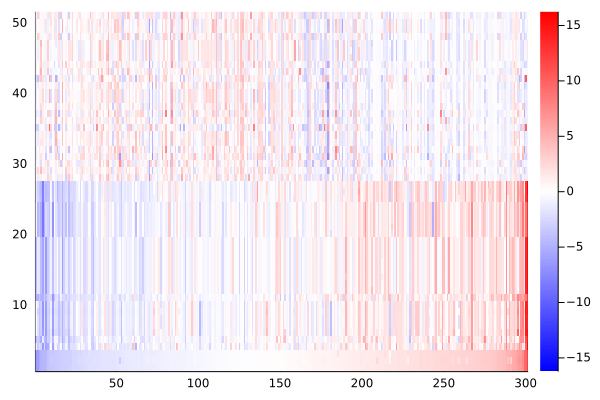

In [268]:
differentialgenes = findall(>(1), mapslices(var, dMprime, dims=1)[:])
cl = maximum(abs.(extrema(dMprime[:, differentialgenes])))
cls = (-cl, cl)
heatmap(dMprime[:, differentialgenes[sortperm(dMprime[1, differentialgenes])]], c=:bwr, clims=cls)

In [269]:
savefig(joinpath(pdir, "samespeciessamedonor_mprime_91-880spdepth_heatmap.pdf"))

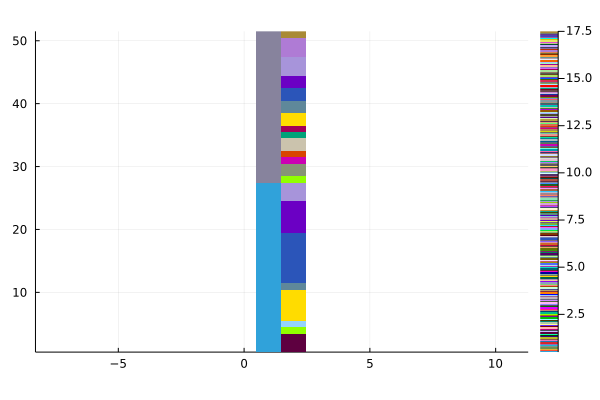

In [271]:
heatmap(hcat(speciesid[idxs], donorid[idxs]), c=:glasbey_hv_n256, ratio=.25)

In [272]:
savefig(joinpath(pdir, "species_donor_catagories_heatmap.pdf"))